In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.impute import KNNImputer
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
import warnings

# Cleaning

In [52]:
flu = pd.read_csv("data.csv")

flu["georegion"] = flu["georegion"].astype(str)
flu["sex"] = flu["sex"].astype(str)
#keep only the whole ch
flu = flu.loc[(flu["georegion"] == "CH") 
            & (flu["sex"] == "all") 
            & (flu["agegroup"] == "all")]
# Select only the desired columns
flu_clean = flu[["incValue", "temporal"]]
flu_clean = flu_clean.rename(columns={"incValue": "value"})

# Remove 'W' from the "temporal" column and replace any non-numeric characters
flu_clean["temporal"] = flu_clean["temporal"].str.replace('W', '')
#CHANGE into datetime
flu_clean["temporal"] = flu_clean["temporal"] + "-1"
flu_clean["temporal"] = pd.to_datetime(flu_clean["temporal"],format='%Y-%W-%w')
flu_clean["temporal"]
#sort by time
flu_clean = flu_clean.sort_values(by='temporal')

flu_clean_imputed = flu_clean.copy()
imputer = KNNImputer(n_neighbors=10)
# Reshape the target column to a 2D array (required by the imputer)
impute_data = flu_clean_imputed['value'].values.reshape(-1, 1)
flu_clean_imputed['value'] = imputer.fit_transform(impute_data)
flu_clean_imputed['value'].isnull().any()
#No missing value

flu_clean_imputed.reset_index()
flu_clean_imputed['temporal'] = pd.to_datetime(flu_clean['temporal'])
flu_clean_imputed = flu_clean_imputed.set_index('temporal')
flu_clean_imputed.index = flu_clean_imputed.index.strftime('%Y-%m-%d')
flu_clean_imputed

,value
temporal,
2013-01-07,89.11
2013-01-14,151.28
2013-01-21,207.82
2013-01-28,302.56
2013-02-04,417.77
...,...
2023-10-09,38.04
2023-10-16,45.46
2023-10-23,59.57


# Decomposition

In [3]:
train = flu_clean_imputed[:520]
test = flu_clean_imputed[520:]
print(train)
print(test)

             value
temporal          
2013-01-07   89.11
2013-01-14  151.28
2013-01-21  207.82
2013-01-28  302.56
2013-02-04  417.77
...            ...
2022-11-14   36.01
2022-11-21   43.40
2022-11-28   70.87
2022-12-05   93.05
2022-12-12  131.60

[520 rows x 1 columns]
             value
temporal          
2022-12-19  233.69
2022-12-26  137.35
2023-01-02   97.11
2023-01-09   95.61
2023-01-16   74.89
2023-01-23   63.35
2023-01-30   83.57
2023-02-06   95.04
2023-02-13   87.49
2023-02-20  108.51
2023-02-27   87.46
2023-03-06   90.91
2023-03-13   77.45
2023-03-20   75.37
2023-03-27   47.61
2023-04-03   46.49
2023-04-10   29.51
2023-04-17   23.41
2023-04-24   23.66
2023-05-01   22.95
2023-05-08   16.22
2023-05-15   12.58
2023-05-22   14.73
2023-05-29    9.30
2023-06-05   12.05
2023-06-12    7.70
2023-06-19   11.29
2023-06-26    6.01
2023-07-03    6.56
2023-07-10    8.69
2023-07-17    5.19
2023-07-24    6.74
2023-07-31    7.43
2023-08-07   17.03
2023-08-14   14.74
2023-08-21   14.74
2023-08

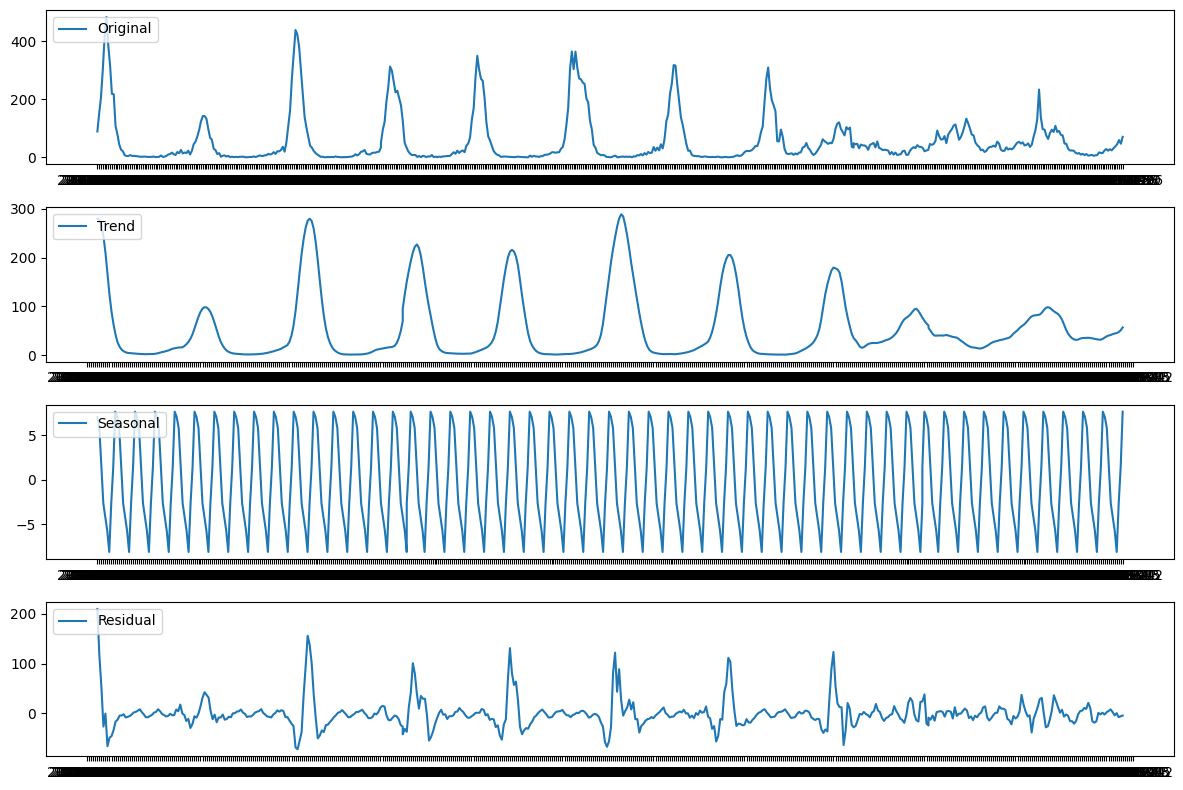

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition
decomp = seasonal_decompose(train['value'], model='additive', period= 10)
trend = decomp.trend
seasonal = decomp.seasonal
residual = decomp.resid

# Plot the components
plt.figure(figsize=(12, 8))

# Original Time Series
plt.subplot(4, 1, 1)
plt.plot(flu_clean_imputed['value'], label='Original')
plt.legend(loc='upper left')

# Trend Component
plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')

# Seasonal Component
plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonal')
plt.legend(loc='upper left')

# Residual Component
plt.subplot(4, 1, 4)
plt.plot(residual, label='Residual')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

# KPSS and ADF

In [5]:
# Perform the KPSS test
result = kpss(train['value'])

# Print the test statistic and p-value
print(f'KPSS Test Statistic: {result[0]}')
print(f'P-value: {result[1]}')

# Compare the test statistic with critical values to make a decision
if result[1] < 0.05:
    print('The time series is non-stationary (reject the null hypothesis), need for differencing')
else:
    print('The time series is stationary (do not reject the null hypothesis), no need for differencing')

KPSS Test Statistic: 0.029891616341576506
P-value: 0.1
The time series is stationary (do not reject the null hypothesis), no need for differencing


/var/folders/__/36t3n6rx1l1fd_9216pzns100000gn/T/ipykernel_57147/2891729970.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(train['value'])


In [6]:
# Perform the ADF test
result = adfuller(train['value'])

# Extract and print the test statistic and p-value
adf_statistic = result[0]
p_value = result[1]
print(f'ADF Test Statistic: {adf_statistic}')
print(f'P-value: {p_value}')

# Compare the test statistic with critical values to make a decision
if p_value < 0.05:
    print('The time series is stationary (reject the null hypothesis)')
else:
    print('The time series is non-stationary (do not reject the null hypothesis)')


ADF Test Statistic: -6.46142409307513
P-value: 1.4400481734043683e-08
The time series is stationary (reject the null hypothesis)


# ACF and PACF

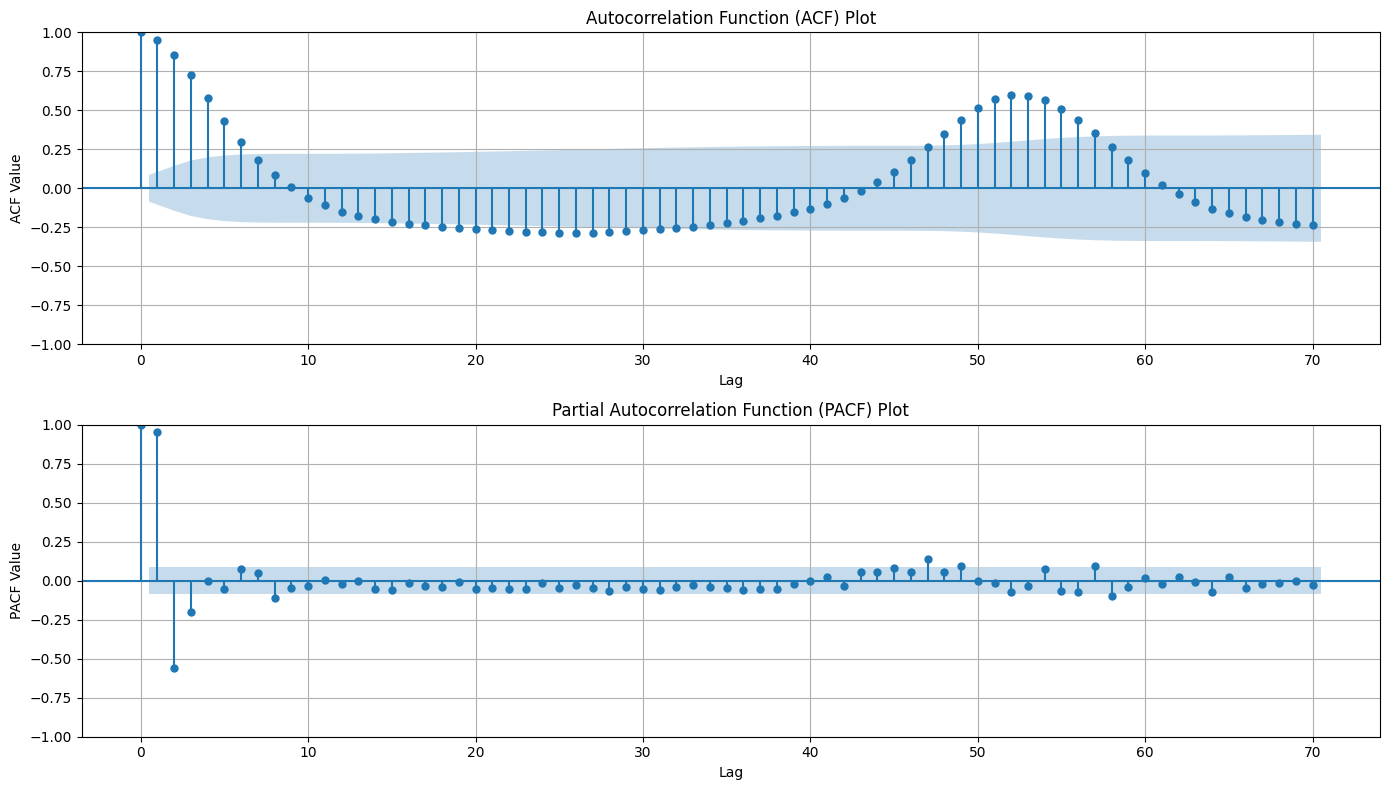

In [7]:
fig, axs = plt.subplots(2, 1, figsize=(14, 8))

# Plot the ACF
plot_acf(train['value'], lags=70, ax=axs[0])  # You can specify the number of lags to display
axs[0].set_title('Autocorrelation Function (ACF) Plot')
axs[0].set_xlabel('Lag')
axs[0].set_ylabel('ACF Value')
axs[0].grid()

# Plot the PACF
plot_pacf(train['value'], lags=70, ax=axs[1])  # You can specify the number of lags to display
axs[1].set_title('Partial Autocorrelation Function (PACF) Plot')
axs[1].set_xlabel('Lag')
axs[1].set_ylabel('PACF Value')
axs[1].grid()

plt.tight_layout()
plt.show() 
# PACF shows the direct effect of each lag on yt, we can see that lag 1, 2, and 3 have the most impact on yt, and a drastic decaying after lag 3
# the decaying PACF also shows the y is not stationary 
# ACF shows that an order of lag 6 has an effect on yt
# Curving ACF suggests transformation??

# Log-transformation

## Redefine Train Test

In [53]:
flu_clean_imputed['value_log'] = flu_clean_imputed['value'] + 1
y_log = np.log(flu_clean_imputed['value_log'])
if (flu_clean_imputed['value_log'] == 0).any():
    print("There are zeros in the column")
else:
    print("No zeros in the column")
flu_clean_imputed["log"] = y_log
flu_clean_imputed = flu_clean_imputed.drop('value_log', axis = 1)
train = flu_clean_imputed[:520]
test = flu_clean_imputed[520:]
print(train)
print(test)

No zeros in the column
             value       log
temporal                    
2013-01-07   89.11  4.501031
2013-01-14  151.28  5.025721
2013-01-21  207.82  5.341473
2013-01-28  302.56  5.715579
2013-02-04  417.77  6.037322
...            ...       ...
2022-11-14   36.01  3.611188
2022-11-21   43.40  3.793239
2022-11-28   70.87  4.274859
2022-12-05   93.05  4.543827
2022-12-12  131.60  4.887337

[520 rows x 2 columns]
             value       log
temporal                    
2022-12-19  233.69  5.458265
2022-12-26  137.35  4.929787
2023-01-02   97.11  4.586089
2023-01-09   95.61  4.570682
2023-01-16   74.89  4.329285
2023-01-23   63.35  4.164337
2023-01-30   83.57  4.437580
2023-02-06   95.04  4.564765
2023-02-13   87.49  4.482890
2023-02-20  108.51  4.696016
2023-02-27   87.46  4.482550
2023-03-06   90.91  4.520810
2023-03-13   77.45  4.362461
2023-03-20   75.37  4.335590
2023-03-27   47.61  3.883829
2023-04-03   46.49  3.860519
2023-04-10   29.51  3.418054
2023-04-17   23.41  3.194

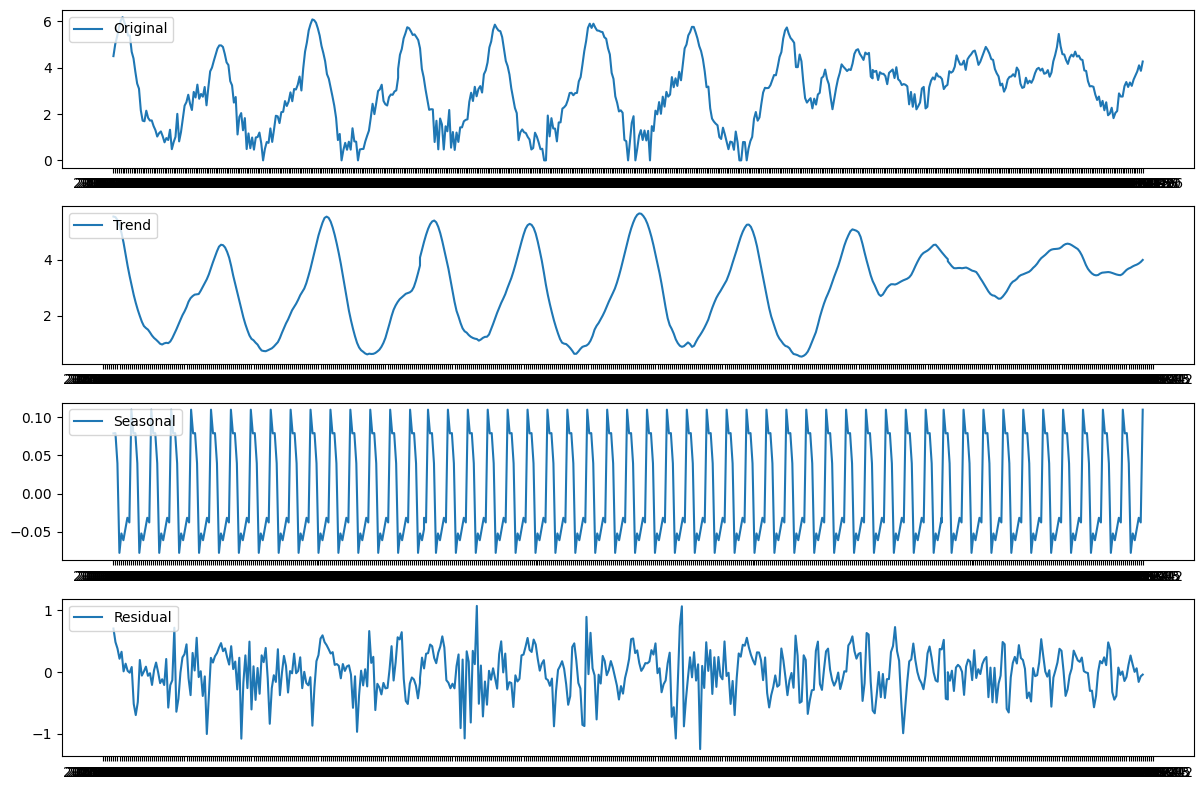

In [9]:
decomp = seasonal_decompose(train['log'], model='additive', period= 10)
trend = decomp.trend
seasonal = decomp.seasonal
residual = decomp.resid

# Plot the components
plt.figure(figsize=(12, 8))

# Original Time Series
plt.subplot(4, 1, 1)
plt.plot(flu_clean_imputed['log'], label='Original')
plt.legend(loc='upper left')

# Trend Component
plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')

# Seasonal Component
plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonal')
plt.legend(loc='upper left')

# Residual Component
plt.subplot(4, 1, 4)
plt.plot(residual, label='Residual')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()
# The pattern in residual disappears afetr log transformation, which implies stationary

## KPSS and ADF with Log_transformation

In [10]:
# Perform the KPSS test
result = kpss(train['log'])

# Print the test statistic and p-value
print(f'KPSS Test Statistic: {result[0]}')
print(f'P-value: {result[1]}')

# Compare the test statistic with critical values to make a decision
if result[1] < 0.05:
    print('The time series is non-stationary (reject the null hypothesis), need for differencing')
else:
    print('The time series is stationary (do not reject the null hypothesis), no need for differencing')

KPSS Test Statistic: 0.292896317669495
P-value: 0.1
The time series is stationary (do not reject the null hypothesis), no need for differencing


/var/folders/__/36t3n6rx1l1fd_9216pzns100000gn/T/ipykernel_57147/1446348268.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(train['log'])


In [11]:
# Perform the ADF test
result = adfuller(train['log'])

# Extract and print the test statistic and p-value
adf_statistic = result[0]
p_value = result[1]
print(f'ADF Test Statistic: {adf_statistic}')
print(f'P-value: {p_value}')

# Compare the test statistic with critical values to make a decision
if p_value < 0.05:
    print('The time series is stationary (reject the null hypothesis)')
else:
    print('The time series is non-stationary (do not reject the null hypothesis)')

ADF Test Statistic: -6.290301683526306
P-value: 3.613000252429696e-08
The time series is stationary (reject the null hypothesis)


## ACF and PACF on Log-transformation

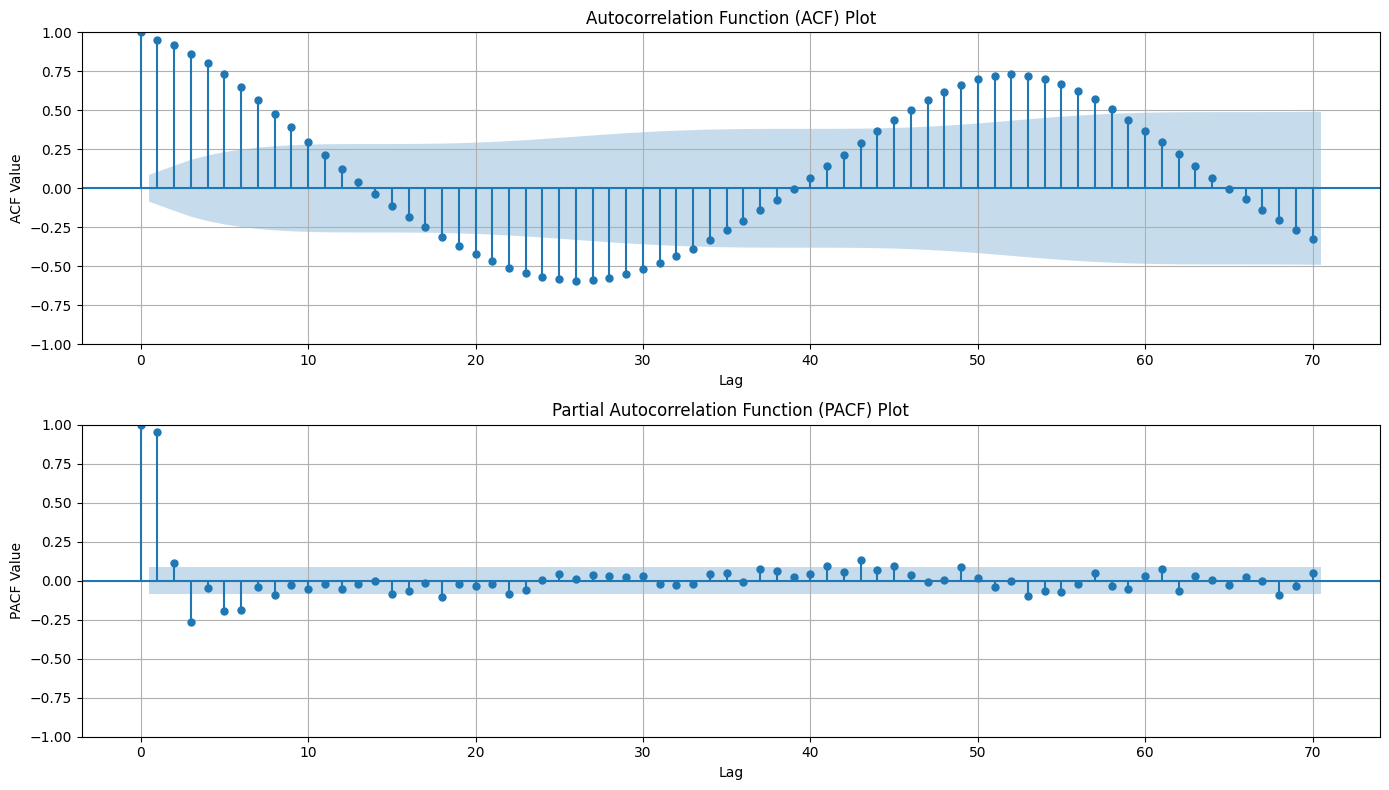

In [12]:
fig, axs = plt.subplots(2, 1, figsize=(14, 8))

# Plot the ACF
plot_acf(train["log"], lags=70, ax=axs[0])  # You can specify the number of lags to display
axs[0].set_title('Autocorrelation Function (ACF) Plot')
axs[0].set_xlabel('Lag')
axs[0].set_ylabel('ACF Value')
axs[0].grid()

# Plot the PACF
plot_pacf(train["log"], lags=70, ax=axs[1])  # You can specify the number of lags to display
axs[1].set_title('Partial Autocorrelation Function (PACF) Plot')
axs[1].set_xlabel('Lag')
axs[1].set_ylabel('PACF Value')
axs[1].grid()

plt.tight_layout()
plt.show() 
# ACF decays slowly with a sine-wave like patterm.
# PACF show no sigficiant spike after 6th lag
# From ACF and PACF we could induce that it could be a AR(6) model, meaning arima (6,0,0)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarnin

                               SARIMAX Results                                
Dep. Variable:                    log   No. Observations:                  520
Model:                 ARIMA(6, 0, 0)   Log Likelihood                -293.450
Date:                Wed, 06 Dec 2023   AIC                            602.901
Time:                        16:22:36   BIC                            636.931
Sample:                             0   HQIC                           616.232
                                - 520                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0157      0.284     10.632      0.000       2.460       3.572
ar.L1          0.8053      0.041     19.499      0.000       0.724       0.886
ar.L2          0.3520      0.047      7.509      0.0

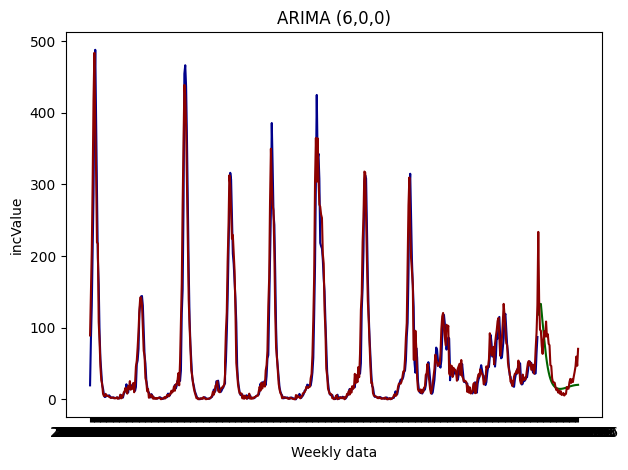

In [14]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import numpy as np
import warnings

model = ARIMA(train["log"], order=(6, 0, 0))
model_arima = model.fit()
print(model_arima.summary())

pred_test = model_arima.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)
pred_test = np.exp(pred_test) - 1
pred_test = pd.DataFrame({'pred': pred_test})
pred_test.index = test.index

pred_train = model_arima.predict(start=0, end=len(train)- 1, dynamic=False)
pred_train = np.exp(pred_train) - 1
pred_train = pd.DataFrame({'pred': pred_train})
pred_train.index = train.index

plt.title("ARIMA (6,0,0)")
plt.ylabel("incValue")
plt.xlabel("Weekly data")
plt.plot(pred_train, color = "darkblue", label = "predicted")
plt.plot(pred_test, color = "darkgreen")
plt.plot(flu_clean_imputed['value'], color = "darkred", label = "actual")
plt.tight_layout()
plt.show

print(mean_squared_error(test["value"], pred_test, squared= False))
# Predition is not very good, we can see it flattens out and converge to a constant.

In [43]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import numpy as np
import warnings
warnings.filterwarnings('ignore')

train = flu_clean_imputed[:260]
H = 52
aic_values = {}
RMSE = {}
average_aic_values = {}
average_rmse_values = {}
d = 0

for p in range(10):
    for q in range(13):
        for t in range(len(train), len(flu_clean_imputed) - 2 * H + 1, H):
            train_end = t
            test_start = train_end + H
            test_end = test_start + H

            current_train = flu_clean_imputed.iloc[:train_end]
            current_test = flu_clean_imputed.iloc[test_start:test_end]
            model = ARIMA(current_train["log"], order=(p, d, q))
            model_arima = model.fit()
            aic_values[(p, d, q)] = model_arima.aic
            for (p, d, q) in aic_values:
                average_aic = np.mean(aic_values[(p, d, q)])
                average_aic_values[(p, d, q)] = average_aic

            pred = model_arima.predict(start=test_start, end=test_end-1, dynamic=False)
            pred = np.exp(pred) - 1
            pred_data = pd.DataFrame({'pred': pred})
            pred_data.index = current_test.index
            rmse_value = mean_squared_error(current_test["value"], pred_data, squared=False)
            RMSE[(p, d, q)] = rmse_value
            for (p, d, q) in RMSE:
                average_rmse = np.mean(RMSE[(p, d, q)])
                average_rmse_values[(p, d, q)] = average_rmse

        print(f"ARIMA({p}, {d}, {q}) with average AIC: {average_aic}, average RMSE is {average_rmse}")

best_pdq_aic = min(average_aic_values, key=average_aic_values.get)
print("Lowest AIC ARIMA is:", best_pdq_aic, average_aic_values[best_pdq_aic])

best_pdq_rmse = min(average_rmse_values, key=average_rmse_values.get)
print("Lowest RMSE ARIMA is:", best_pdq_rmse, average_rmse_values[best_pdq_rmse])

ARIMA(0, 0, 0) with average AIC: 1612.2058122762883, average RMSE is 51.88235743158978
ARIMA(0, 0, 1) with average AIC: 1243.0795802143725, average RMSE is 51.83479850648817
ARIMA(0, 0, 2) with average AIC: 967.7541453301046, average RMSE is 51.79222146145333
ARIMA(0, 0, 3) with average AIC: 858.6961357074848, average RMSE is 51.769828136874665
ARIMA(0, 0, 4) with average AIC: 763.8955214037098, average RMSE is 51.72373130026605
ARIMA(0, 0, 5) with average AIC: 707.9830582366722, average RMSE is 51.68240002258404
ARIMA(0, 0, 6) with average AIC: 666.5119031445057, average RMSE is 51.64446894557566
ARIMA(0, 0, 7) with average AIC: 640.3453666790887, average RMSE is 51.59874909998402
ARIMA(0, 0, 8) with average AIC: 620.2460228984182, average RMSE is 51.55904254337791
ARIMA(0, 0, 9) with average AIC: 591.4321419492757, average RMSE is 51.55500608472912
ARIMA(0, 0, 10) with average AIC: 587.6516358586147, average RMSE is 51.545906260386715
ARIMA(0, 0, 11) with average AIC: 570.90076933294

                               SARIMAX Results                                
Dep. Variable:                    log   No. Observations:                  520
Model:                 ARIMA(7, 0, 8)   Log Likelihood                -279.167
Date:                Wed, 06 Dec 2023   AIC                            592.335
Time:                        17:47:24   BIC                            664.650
Sample:                             0   HQIC                           620.664
                                - 520                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0110      0.203     14.817      0.000       2.613       3.409
ar.L1          0.2938      0.182      1.613      0.107      -0.063       0.651
ar.L2          1.4903      0.194      7.691      0.0

<function matplotlib.pyplot.show(close=None, block=None)>

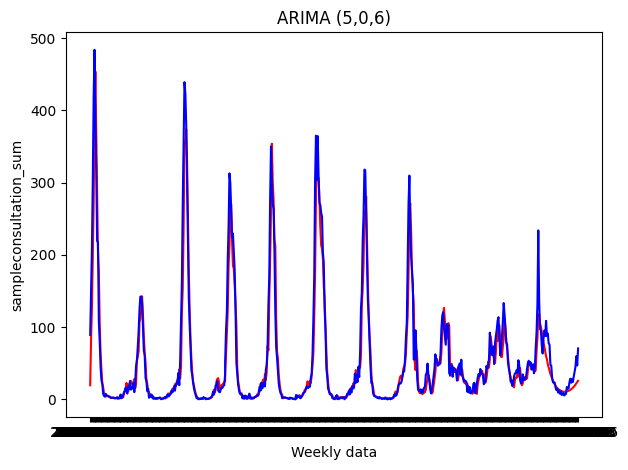

In [48]:
train = flu_clean_imputed[:520]
test = flu_clean_imputed[520:]

model = ARIMA(train["log"], order=(7, 0, 8))
model_arima = model.fit()
print(model_arima.summary())

pred = model_arima.predict(start=0, end=len(flu_clean_imputed) - 1, dynamic=False)
pred = np.exp(pred) - 1
pred_data = pd.DataFrame({'pred': pred})
pred_data.index = flu_clean_imputed.index

plt.title("ARIMA (5,0,6)")
plt.ylabel("sampleconsultation_sum")
plt.xlabel("Weekly data")
plt.plot(pred_data, color = "red", label = "predicted")
plt.plot(flu_clean_imputed['value'], color = "blue", label = "actual")
plt.tight_layout()
plt.show

## 1st Order Differencing

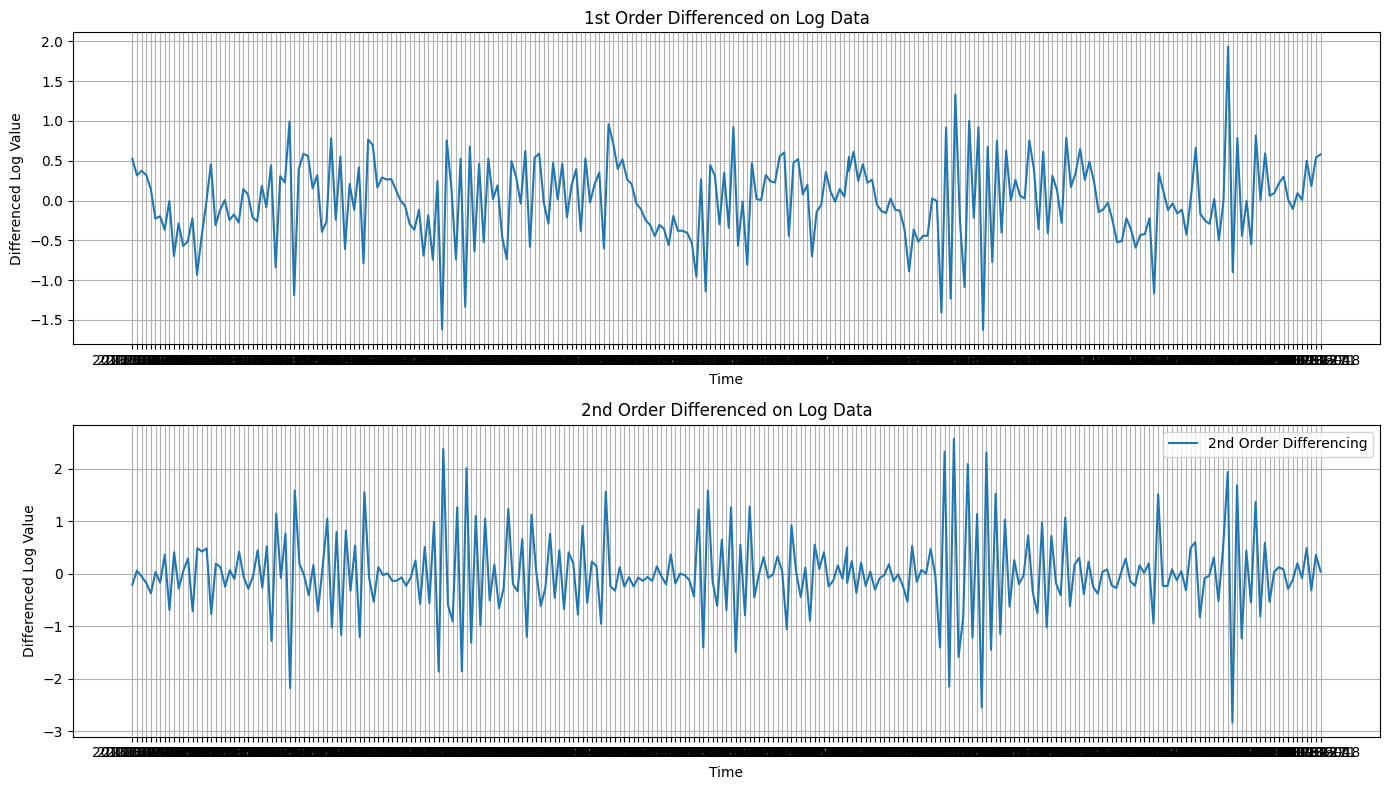

In [12]:
diff = pd.DataFrame(train["log"].diff())
diff = diff.dropna()

diff2 = pd.DataFrame(diff["log"].diff())
diff2 = diff2.dropna()

fig, axs = plt.subplots(2, 1, figsize=(14, 8))

# Plot for 1st Order Differencing
axs[0].plot(diff, label='1st Order Differencing')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Differenced Log Value')
axs[0].set_title('1st Order Differenced on Log Data')
axs[0].grid()  # Add grid to the first plot

# Plot for 2nd Order Differencing
axs[1].plot(diff2, label='2nd Order Differencing')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Differenced Log Value')
axs[1].set_title('2nd Order Differenced on Log Data')
axs[1].grid()

plt.tight_layout()
plt.legend()
plt.show()
# Even though the tests above tells us there is no need for differencing, we still do it but the pattern persists.

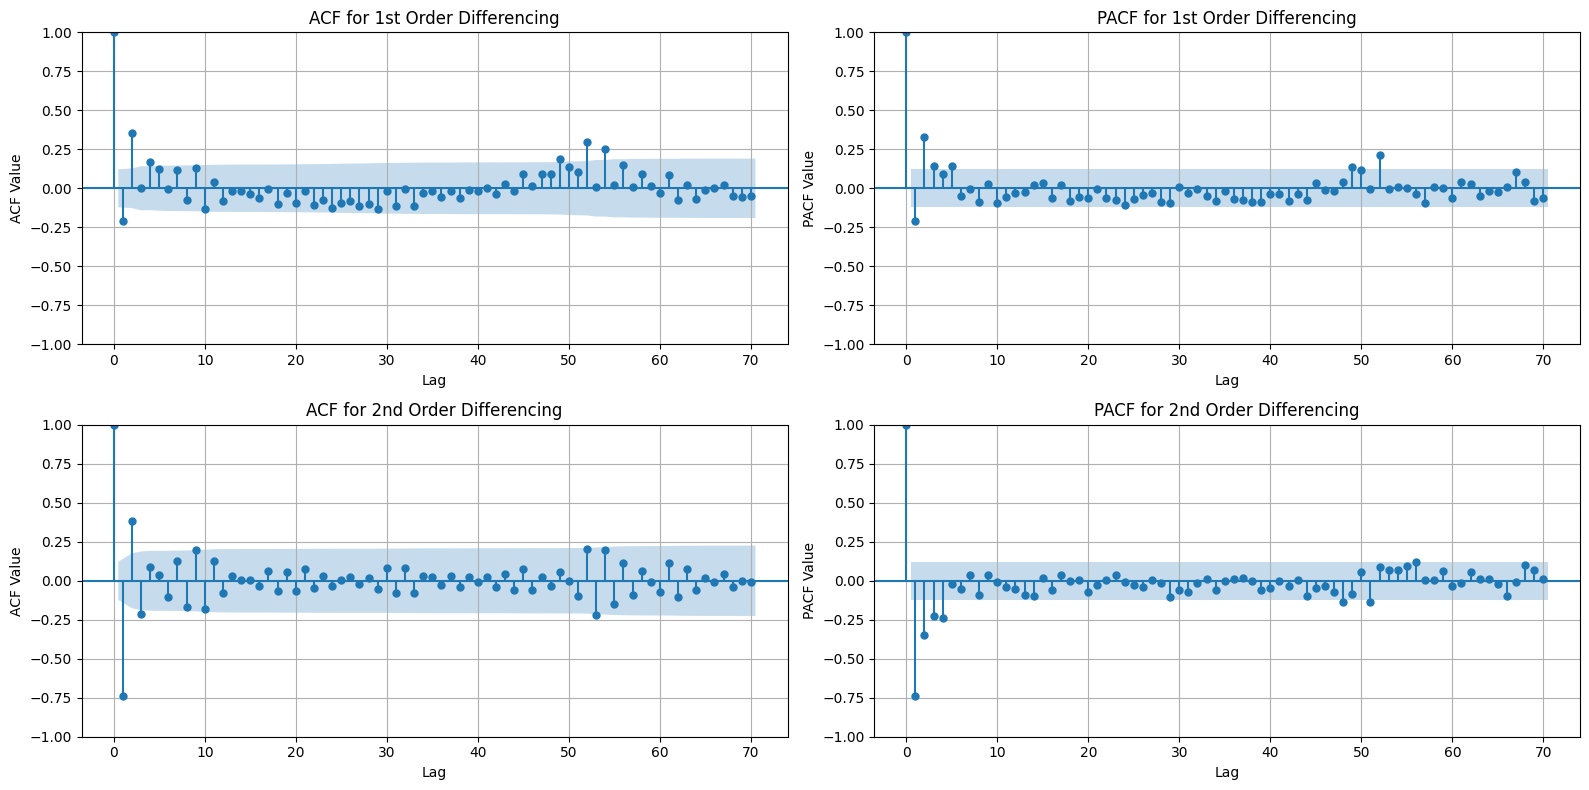

In [37]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8))

# Plot ACF for diff
plot_acf(diff, lags=70, ax=axs[0, 0])
axs[0, 0].set_title('ACF for 1st Order Differencing')
axs[0, 0].set_xlabel('Lag')
axs[0, 0].set_ylabel('ACF Value')
axs[0, 0].grid()

# Plot PACF for diff
plot_pacf(diff, lags=70, ax=axs[0, 1])
axs[0, 1].set_title('PACF for 1st Order Differencing')
axs[0, 1].set_xlabel('Lag')
axs[0, 1].set_ylabel('PACF Value')
axs[0, 1].grid()

# Plot ACF for diff2
plot_acf(diff2, lags=70, ax=axs[1, 0])
axs[1, 0].set_title('ACF for 2nd Order Differencing')
axs[1, 0].set_xlabel('Lag')
axs[1, 0].set_ylabel('ACF Value')
axs[1, 0].grid()

# Plot PACF for diff2
plot_pacf(diff2, lags=70, ax=axs[1, 1])
axs[1, 1].set_title('PACF for 2nd Order Differencing')
axs[1, 1].set_xlabel('Lag')
axs[1, 1].set_ylabel('PACF Value')
axs[1, 1].grid()

plt.tight_layout()
plt.show()
# Decaying ACF and PACF for 1st order differencing and 2nd order differencing
# possible another differencing method?

## Seasonal Differencing

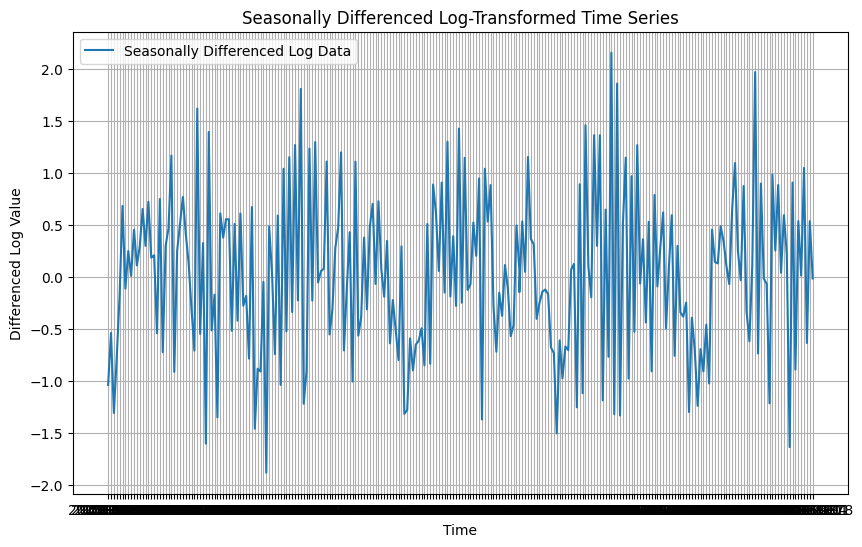

In [40]:
# Define the lag (seasonal period)
lag = 12 # For yearly seasonality (e.g., weekly data)

# Perform seasonal differencing on the log-transformed data
seasonal_differenced_data = diff.diff(lag)

# Drop NaN values (resulting from the diff operation)
seasonal_differenced_data = seasonal_differenced_data.dropna()

# Now, seasonal_differenced_data contains the seasonally differenced log-transformed data
plt.figure(figsize=(10, 6))
plt.plot(seasonal_differenced_data, label='Seasonally Differenced Log Data')
plt.title('Seasonally Differenced Log-Transformed Time Series')
plt.xlabel('Time')
plt.ylabel('Differenced Log Value')
plt.legend()
plt.grid()
plt.show()
# After seasonl differencing on log-transformation, it seems to be stationary.

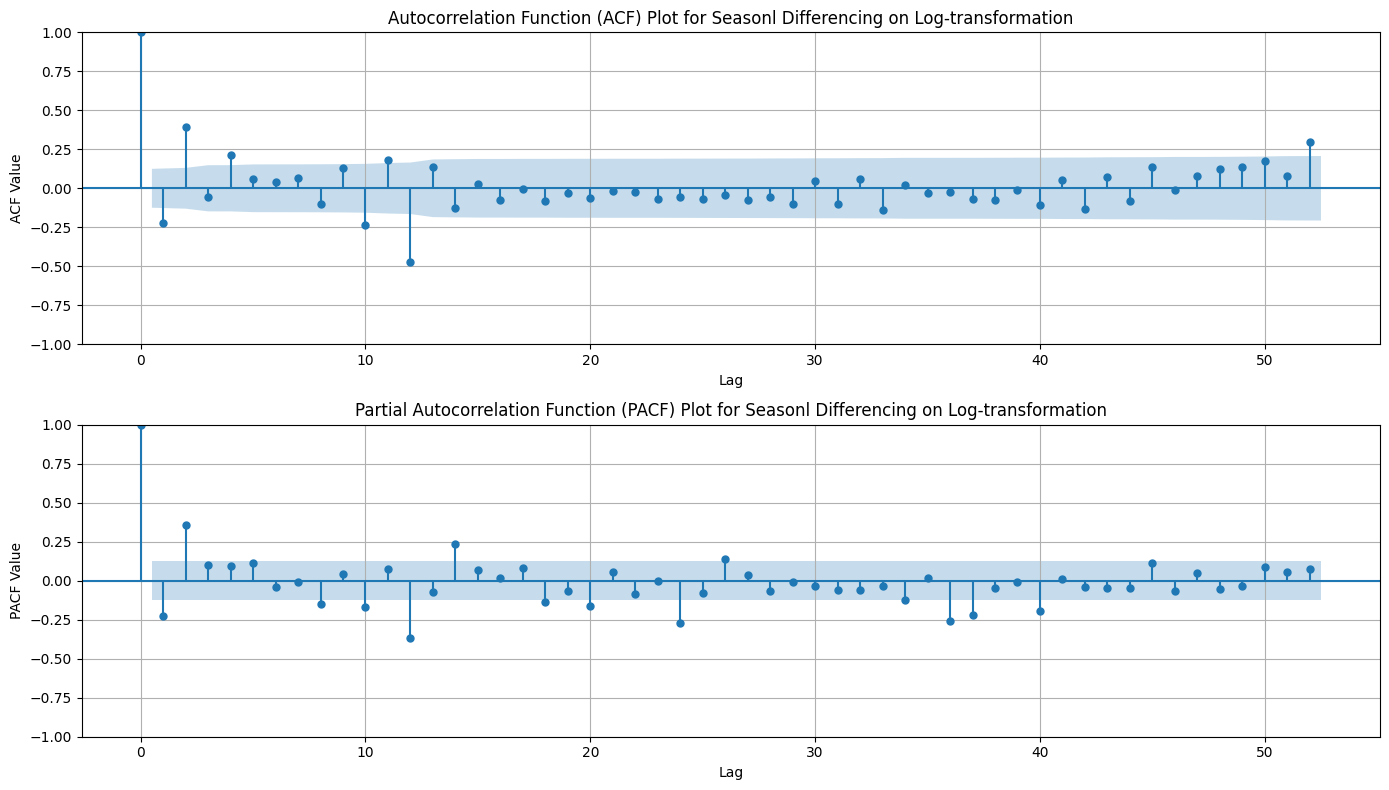

In [39]:
fig, axs = plt.subplots(2, 1, figsize=(14, 8))

# Plot the ACF
plot_acf(seasonal_differenced_data, lags=52, ax=axs[0])  # You can specify the number of lags to display
axs[0].set_title('Autocorrelation Function (ACF) Plot for Seasonl Differencing on Log-transformation')
axs[0].set_xlabel('Lag')
axs[0].set_ylabel('ACF Value')
axs[0].grid()

# Plot the PACF
plot_pacf(seasonal_differenced_data, lags=52, ax=axs[1])  # You can specify the number of lags to display
axs[1].set_title('Partial Autocorrelation Function (PACF) Plot for Seasonl Differencing on Log-transformation')
axs[1].set_xlabel('Lag')
axs[1].set_ylabel('PACF Value')
axs[1].grid()

plt.tight_layout()
plt.show()
# Decay ACF and PACF is a good sign for stationality
#From ACF and PACF we could induce that the optimum mivong average is 10 and the autoregressive order is 4.

# ARIMA

expanding cross validation will be used because the dataset is quite small with unexpected spikes

# SARIMA

In [54]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import numpy as np
import warnings
warnings.filterwarnings('ignore')

train = flu_clean_imputed[:260]
H = 52
aic_values = {}
RMSE = {}
average_aic_values = {}
average_rmse_values = {}

p = 7
d = 0
q = 8
D = 1
S = 12

for P in range(10):
    for Q in range(13):
        for t in range(len(train), len(flu_clean_imputed) - 2 * H + 1, H):
            train_end = t
            test_start = train_end + H
            test_end = test_start + H

            current_train = flu_clean_imputed.iloc[:train_end]
            current_test = flu_clean_imputed.iloc[test_start:test_end]

            model_sarima = SARIMAX(current_train['log'],
                                    order=(p, d, q),
                                    seasonal_order=(P, D, Q, S)).fit()
            aic_values[(p, d, q, P, D, Q, S)] = model_sarima.aic

            for (p, d, q, P, D, Q, S) in aic_values:
                average_aic = np.mean(aic_values[(p, d, q, P, D, Q, S)])
                average_aic_values[(p, d, q, P, D, Q, S)] = average_aic

            pred_sarima = model_sarima.predict(start=test_start, end=test_end-1, dynamic=False)
            pred_sarima = np.exp(pred_sarima) - 1
            pred_data_sarima = pd.DataFrame({'pred': pred_sarima})
            pred_data_sarima.index = current_test.index
            rmse_value = mean_squared_error(current_test["value"], pred_data, squared=False)
            RMSE[(p, d, q, P, D, Q, S)] = rmse_value

            for (p, d, q, P, D, Q, S) in RMSE:
                average_aic = np.mean(aic_values[(p, d, q)])
                average_aic_values[(p, d, q)] = average_aic


        print(f"SARIMA({p}, {d}, {q}) with average AIC: {average_aic}, average RMSE is {average_rmse}")

best_pdq_aic = min(average_aic_values, key=average_aic_values.get)
print("Lowest AIC SARIMA is:", best_pdq_aic, average_aic_values[best_pdq_aic])

best_pdq_rmse = min(average_rmse_values, key=average_rmse_values.get)
print("Lowest RMSE SARIMA is:", best_pdq_rmse, average_rmse_values[best_pdq_rmse])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.46677D-01    |proj g|=  8.24993D-02

At iterate    5    f=  9.31704D-01    |proj g|=  1.14998D-01


 This problem is unconstrained.



At iterate   10    f=  8.67816D-01    |proj g|=  1.08079D-01

At iterate   15    f=  8.56019D-01    |proj g|=  6.07556D-02

At iterate   20    f=  8.42251D-01    |proj g|=  2.23590D-02

At iterate   25    f=  8.38292D-01    |proj g|=  1.23671D-02

At iterate   30    f=  8.34391D-01    |proj g|=  6.99452D-02

At iterate   35    f=  8.31533D-01    |proj g|=  8.61675D-03

At iterate   40    f=  8.31261D-01    |proj g|=  1.18252D-02

At iterate   45    f=  8.30985D-01    |proj g|=  6.32477D-03

At iterate   50    f=  8.30600D-01    |proj g|=  1.30590D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     55   

ValueError: Found input variables with inconsistent numbers of samples: [52, 567]